In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

In [28]:
TIMESTEPS = 35040 # 365 days with 15min resolution
V_REF = 1.0 # pu
V_NOM = 416 # V

CURRENT_SCENARIO = '1_'

working_folder = os.getcwd()
root_dir = os.path.abspath(os.path.join(working_folder, os.pardir))
data_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO, 'time_series_calculation')
network_path = os.path.join(root_dir, 'data', CURRENT_SCENARIO, 'network')

# load network
net = pp.from_json(os.path.join(network_path, 'IEEE_modified_LV_Feeder.json'))
# load required dataframes
buses_df = pd.read_csv(os.path.join(network_path,'buses.csv'))
lines_df = pd.read_csv(os.path.join(network_path,'lines.csv'))

## Importing data for plotting

A pandas dataframe is made from the output '.json' file This dataframe will be used for plotting results using matplotlib

In [29]:
# Power Values from secondary of the transformer
tr_p = os.path.join(data_path,'res_trafo','p_lv_mw.json')
tr_q = os.path.join(data_path,'res_trafo','q_lv_mvar.json')

#pandapower Results
df_tr = pd.DataFrame()
df_tr['P'] = pd.read_json(tr_p)*-1e3
df_tr['Q'] = pd.read_json(tr_q)*-1e3

#Magnitude and angle of voltages 
pp_vm = os.path.join(data_path,'res_bus','vm_pu.json')

#Line loading
pp_ld = os.path.join(data_path,'res_line','loading_percent.json')

#pandapower Results
df_pp_vm = pd.read_json(pp_vm)*(416)
df_pp_ld = pd.read_json(pp_ld)

# This is required since json makes keys as string type, the index order is like 1, 10, 100 ,...
df_pp_vm.index = df_pp_vm.index.astype(np.int64)
df_pp_vm = df_pp_vm.sort_index()

df_pp_ld.index = df_pp_ld.index.astype(np.int64)
df_pp_ld = df_pp_ld.sort_index()

df_tr.index = df_tr.index.astype(np.int64)
df_tr = df_tr.sort_index()

In [30]:
df_tr['P'].max()

293.4237551

## Plotting Results

The following data is generated :
- pandapower voltage and power (time-series values)

In [31]:
# Convert the DataFrame to a numpy array
bus_voltage_data_array = df_pp_vm.values
line_loading_data_array = df_pp_ld.values

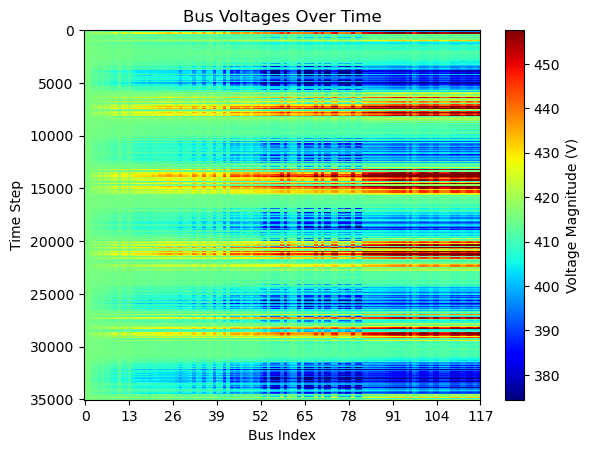

In [32]:
# Heatmap - Votlage Magnitudes
plt.imshow(bus_voltage_data_array, aspect='auto', cmap='jet', vmin=416*0.9, vmax=416*1.1, interpolation='none')
plt.colorbar(label='Voltage Magnitude (V)')

# Set labels and show the plot
plt.xlabel('Bus Index')
plt.ylabel('Time Step')
plt.title('Bus Voltages Over Time')

N_buses_print = 13
bus_numbers = list(range(0,len(buses_df)+1,N_buses_print))
plt.xticks(bus_numbers)

plt.show()

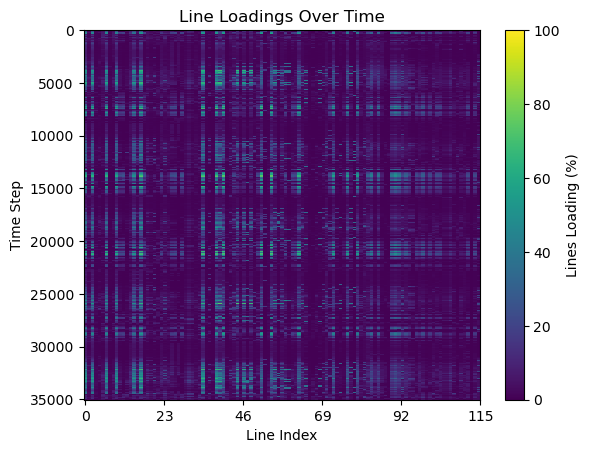

In [33]:
# Heatmap - Line Loadings %
plt.imshow(line_loading_data_array, aspect='auto', cmap='viridis', vmin=0, vmax=100, interpolation='none')
plt.colorbar(label='Lines Loading (%)')

# Set labels and show the plot
plt.xlabel('Line Index')
plt.ylabel('Time Step')
plt.title('Line Loadings Over Time')

N_lines_print = 23
line_numbers = list(range(0,len(lines_df)+1,N_lines_print))
plt.xticks(line_numbers)

plt.show()

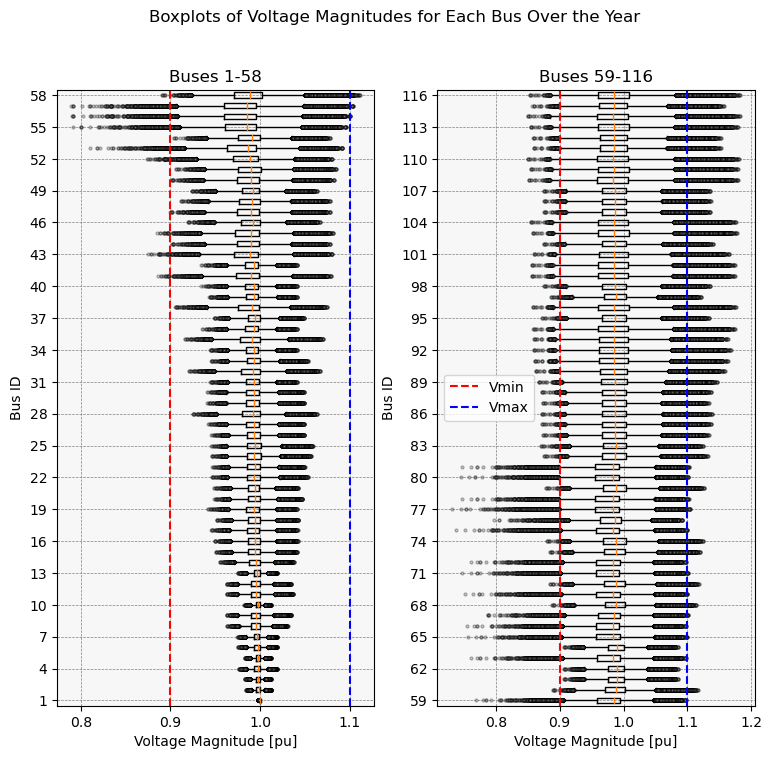

In [34]:
# BOX PLOTS - BUS VOLTAGE MAGNITUDES

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 8))
# fig, axes = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Select the number of y-axis ticks you want to display
num_ticks = 32  # Adjust this number as needed
# Calculate the step size to evenly distribute ticks
step_size = max(1, len(bus_voltage_data_array[0]) // num_ticks)

# Customizing the appearance of the outliers
flierprops = dict(marker='o', markerfacecolor='gray', markersize=2, linestyle='none', alpha=0.3)

# Plot for the first 58 arrays (left subplot)
boxplot_left = axes[0].boxplot(bus_voltage_data_array[:,1:59] / V_NOM, vert=False, flierprops=flierprops)
axes[0].set_xlabel('Voltage Magnitude [pu]')
axes[0].set_ylabel('Bus ID')
axes[0].set_title('Buses 1-58')

# Add vertical lines at values -2 and 2
axes[0].axvline(x=0.9*V_REF, color='r', linestyle='--', label='Vmin')
axes[0].axvline(x=1.1*V_REF, color='b', linestyle='--', label='Vmax')

# Set y-axis ticks and labels
tick_positions_left = np.arange(1, 59, step_size)
axes[0].set_yticks(tick_positions_left)
axes[0].set_yticklabels(tick_positions_left)  # Add 1 to start indexing from 1

# create grid and set darker background
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[0].set_facecolor('#f7f7f7')  # Set a darker background 


# Plot for the remaining arrays (right subplot)
boxplot_right = axes[1].boxplot(bus_voltage_data_array[:,59:] / V_NOM, vert=False, flierprops=flierprops)
axes[1].set_xlabel('Voltage Magnitude [pu]')
axes[1].set_ylabel('Bus ID')
axes[1].set_title('Buses 59-116')

# Add vertical lines at values Vmin and Vmax
axes[1].axvline(x=0.9*V_REF, color='r', linestyle='--', label='Vmin')
# THIS IS ADJUSTED TO 455 TO SHOW OVERVOTLAGE
axes[1].axvline(x=1.1*V_REF, color='b', linestyle='--', label='Vmax')

# Set y-axis ticks and labels for the right subplot
tick_positions_right = np.arange(1, len(bus_voltage_data_array[1][58:]), step_size)
axes[1].set_yticks(tick_positions_right)
axes[1].set_yticklabels(tick_positions_right + 58)  # Add 59 to start indexing from 59

#create grid and set darker background
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[1].set_facecolor('#f7f7f7')  

# Adjust layout and spacing between subplots
# plt.subplots_adjust(wspace=0.4)

# Display legend on the right subplot
axes[1].legend()

plt.suptitle('Boxplots of Voltage Magnitudes for Each Bus Over the Year')

plt.savefig(os.path.join(network_path, 'congestion', 'boxplot_voltage_magnitudes.png'))

plt.show()

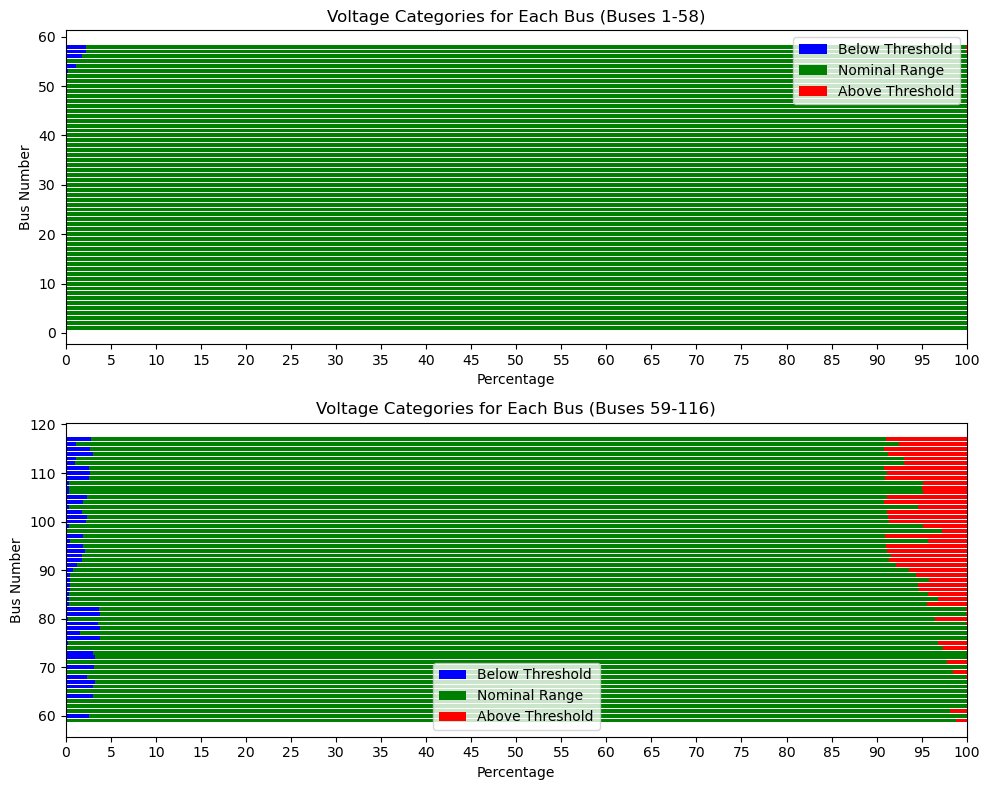

In [38]:
# BARS OF VOLTAGE VIOLATIONS PERCENTAGES

# Plot bars with percentages of voltage values falling in different ranges (undervotlage, nominal, overvotlage) 

lower_threshold = V_NOM * 0.9
upper_threshold = V_NOM * 1.1

# Create lists to store percentages for each category
below_threshold_percentages = []
nominal_range_percentages = []
above_threshold_percentages = []

for column in range(bus_voltage_data_array.shape[1]):
    # Count values in each category
    below_threshold_count = np.sum(bus_voltage_data_array[:, column] < lower_threshold)
    nominal_range_count = np.sum(
        (bus_voltage_data_array[:, column] >= lower_threshold) & (bus_voltage_data_array[:, column] <= upper_threshold))
    above_threshold_count = np.sum(bus_voltage_data_array[:, column] > upper_threshold)

    # Calculate percentages
    total_count = bus_voltage_data_array.shape[0]
    below_threshold_percentage = (below_threshold_count / total_count) * 100
    nominal_range_percentage = (nominal_range_count / total_count) * 100
    above_threshold_percentage = (above_threshold_count / total_count) * 100

    # Append percentages to the lists
    below_threshold_percentages.append(below_threshold_percentage)
    nominal_range_percentages.append(nominal_range_percentage)
    above_threshold_percentages.append(above_threshold_percentage)


# Split buses into two groups (1-58 and 59-116)
half_bus_count = bus_voltage_data_array.shape[1] // 2
bar_positions_first_half = np.arange(1, half_bus_count + 1)
bar_positions_second_half = np.arange(half_bus_count + 1, bus_voltage_data_array.shape[1] + 1)

# Plot the bar graphs
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First half
bar1_first = axs[0].barh(bar_positions_first_half, below_threshold_percentages[:half_bus_count], color='blue',
                         label='Below Threshold')
bar2_first = axs[0].barh(bar_positions_first_half, nominal_range_percentages[:half_bus_count],
                         left=below_threshold_percentages[:half_bus_count], color='green', label='Nominal Range')
bar3_first = axs[0].barh(bar_positions_first_half, above_threshold_percentages[:half_bus_count],
                         left=np.array(below_threshold_percentages[:half_bus_count]) +
                              np.array(nominal_range_percentages[:half_bus_count]), color='red',
                         label='Above Threshold')

# Second half
bar1_second = axs[1].barh(bar_positions_second_half, below_threshold_percentages[half_bus_count:], color='blue',
                          label='Below Threshold')
bar2_second = axs[1].barh(bar_positions_second_half, nominal_range_percentages[half_bus_count:],
                          left=below_threshold_percentages[half_bus_count:], color='green', label='Nominal Range')
bar3_second = axs[1].barh(bar_positions_second_half, above_threshold_percentages[half_bus_count:],
                          left=np.array(below_threshold_percentages[half_bus_count:]) +
                               np.array(nominal_range_percentages[half_bus_count:]), color='red',
                          label='Above Threshold')

# Add labels, legend, and title
axs[0].set_xlabel('Percentage')
axs[0].set_ylabel('Bus Number')
axs[0].set_title('Voltage Categories for Each Bus (Buses 1-58)')
axs[0].legend()

axs[1].set_xlabel('Percentage')
axs[1].set_ylabel('Bus Number')
axs[1].set_title('Voltage Categories for Each Bus (Buses 59-116)')
axs[1].legend()

# Set x-axis ticks to multiples of 5
axs[0].set_xticks(np.arange(0, 101, 5))
axs[1].set_xticks(np.arange(0, 101, 5))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# TODO: Change the plots to vertical maybe instead of horizontal, convert V to pu, put a grid behind with light grey color
#       figure out what I will do with the outliers

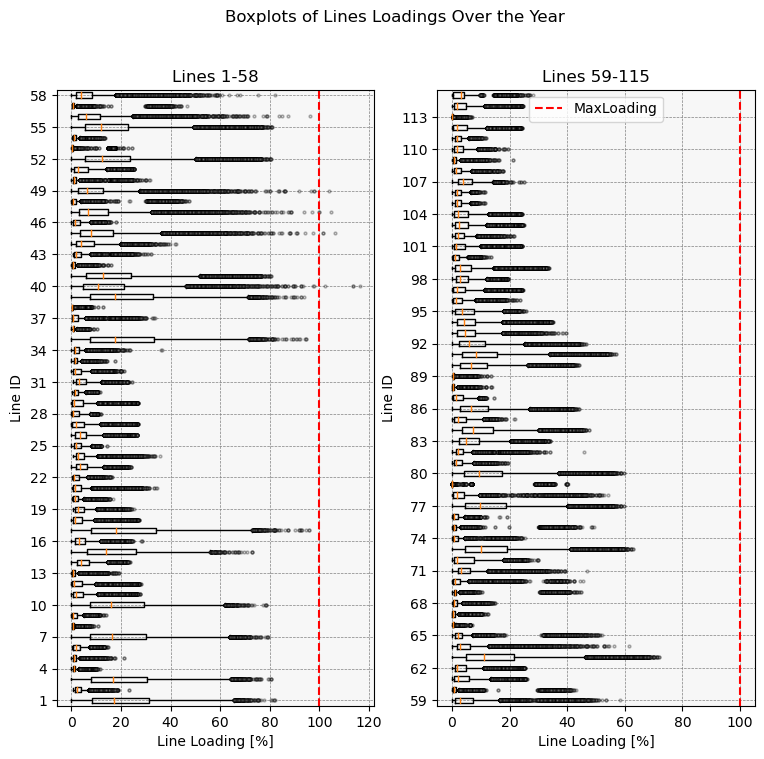

In [35]:
# BOX PLOT - LINE LOADINGS

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 8))
# fig, axes = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Select the number of y-axis ticks you want to display
num_ticks = 32  # Adjust this number as needed
# Calculate the step size to evenly distribute ticks
step_size = max(1, len(line_loading_data_array[0]) // num_ticks)

# Customizing the appearance of the outliers
flierprops = dict(marker='o', markerfacecolor='gray', markersize=2, linestyle='none', alpha=0.3)

# Plot for the first 58 arrays (left subplot)
boxplot_left = axes[0].boxplot(line_loading_data_array[:,0:58], vert=False, flierprops=flierprops)
axes[0].set_xlabel('Line Loading [%]')
axes[0].set_ylabel('Line ID')
axes[0].set_title('Lines 1-58')

# Add vertical lines at max Loading
axes[0].axvline(x=100, color='r', linestyle='--', label='MaxLoading')

# Set y-axis ticks and labels
tick_positions_left = np.arange(1, 59, step_size)
axes[0].set_yticks(tick_positions_left)
axes[0].set_yticklabels(tick_positions_left)  # Add 1 to start indexing from 1

# create grid and set darker background
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[0].set_facecolor('#f7f7f7')  # Set a darker background 

# Plot for the remaining arrays (right subplot)
boxplot_right = axes[1].boxplot(line_loading_data_array[:,58:], vert=False, flierprops=flierprops)
axes[1].set_xlabel('Line Loading [%]')
axes[1].set_ylabel('Line ID')
axes[1].set_title('Lines 59-115')

# Add vertical lines at max Loading
axes[1].axvline(x=100, color='r', linestyle='--', label='MaxLoading')

# Set y-axis ticks and labels for the right subplot
tick_positions_right = np.arange(1, len(line_loading_data_array[1][58:]), step_size)
axes[1].set_yticks(tick_positions_right)
axes[1].set_yticklabels(tick_positions_right + 58)  # Add 59 to start indexing from 59

# create grid and set darker background
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[1].set_facecolor('#f7f7f7')  # Set a darker background 

# Adjust layout and spacing between subplots
# plt.subplots_adjust(wspace=0.4)

# Display legend on the right subplot
axes[1].legend()

plt.suptitle('Boxplots of Lines Loadings Over the Year')

plt.savefig(os.path.join(network_path, 'congestion', 'boxplot_lines_overloading.png'))

plt.show()